In [6]:
import pandas as pd
from simulation import Simulation

from models.building_model import BuildingModel
from models.heat_pump import HeatPump
from models.hyst_controller import HystController
from models.weather_model import LocalWeather

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib ipympl

In [7]:
sim = Simulation(True, 'output_data.pkl')

building   = BuildingModel('building')
heatpump   = HeatPump('heatpump')
controller = HystController('controller', hyst=1.2)
weather    = LocalWeather('weather')

sim.add_model(building,   watch_values=['T_room1', 'T_room2', 'T_amb', 'apparent_zenith', 'dhi', 'ghi']  )
sim.add_model(heatpump,   watch_values=['state', 'P_el', 'dot_Q_hp'])
sim.add_model(controller, watch_values=['T_is', 'state'])
sim.add_model(weather,    watch_values=['apparent_zenith', 'dhi', 'ghi'])

sim.connect(weather, building, ('T_air', 'T_amb'), 'apparent_zenith', 'azimuth', 'dni', 'dhi', 'ghi')
sim.connect(weather, heatpump, ('T_air', 'T_source'))
sim.connect(heatpump, building, ('dot_Q_hp', 'dot_Q_heat'))
sim.connect(controller, heatpump, ('state', 'state'))

sim.connect(building, heatpump, ('T_room1', 'T_sink'), time_shifted=True, init_values={'T_room1': 21})
sim.connect(building, controller, ('T_room1', 'T_is'), time_shifted=True, init_values={'T_room1': 21})

times = pd.date_range('2021-01-01 00:00:00', '2021-01-03 00:00:00', freq='1min', tz='UTC+01:00')

sim.run(times)

Progress: 100%|██████████| 2881/2881 [00:05<00:00, 492.96Steps/s]


In [8]:
df = pd.read_pickle('output_data.pkl')

In [9]:
for col in df.columns:
    # Attempt to convert the column to numeric
    df[col] = pd.to_numeric(df[col], errors='ignore')
df.head()

model                       building                                         \
i/o                          outputs            inputs                        
attribute                    T_room1    T_room2  T_amb apparent_zenith  dhi   
2021-01-01 00:00:00+01:00  19.999177  20.997384  -1.71      155.032293  0.0   
2021-01-01 00:01:00+01:00  20.014553  20.994776  -1.71      155.032293  0.0   
2021-01-01 00:02:00+01:00  20.029909  20.992183  -1.71      155.032293  0.0   
2021-01-01 00:03:00+01:00  20.045244  20.989604  -1.71      155.032293  0.0   
2021-01-01 00:04:00+01:00  20.060560  20.987040  -1.71      155.032293  0.0   

model                          heatpump                       controller  \
i/o                              inputs outputs                   inputs   
attribute                  ghi    state    P_el      dot_Q_hp       T_is   
2021-01-01 00:00:00+01:00  0.0      off       0      0.000000  21.000000   
2021-01-01 00:01:00+01:00  0.0       on    2000  13503.468007  19.999177   
2021-01-01 00:02:00+01:00  0.0       on    2000  13494.618436  20.014553   
2021-01-01 00:03:00+01:00  0.0       on    2000  13485.792964  20.029909   
2021-01-01 00:04:00+01:00  0.0       on    2000  13476.991490  20.045244   

model                                     weather            
i/o                       outputs         outputs            
attribute                   state apparent_zenith  dhi  ghi  
2021-01-01 00:00:00+01:00     off      155.032293  0.0  0.0  
2021-01-01 00:01:00+01:00      on             NaN  NaN  NaN  
2021-01-01 00:02:00+01:00      on             NaN  NaN  NaN  
2021-01-01 00:03:00+01:00      on             NaN  NaN  NaN  
2021-01-01 00:04:00+01:00      on             NaN  NaN  NaN

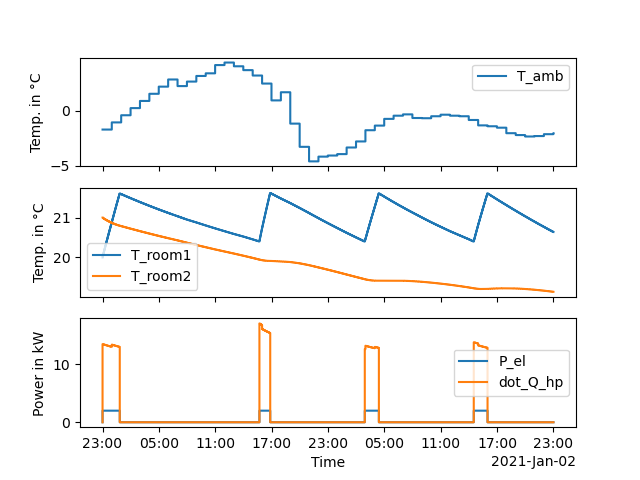

In [19]:
df = df

df.ffill()
dtindex = df.index 

fig, ax = plt.subplots(3, sharex=True)
ax[0].plot(dtindex, df.loc[:, ('building', 'inputs', 'T_amb')], label='T_amb', drawstyle='steps')
ax[0].legend()
ax[0].set_ylabel('Temp. in °C')

# Roomtemperatures
ax[1].plot(dtindex, df.loc[:, ('building', 'outputs', 'T_room1')], label='T_room1', drawstyle='steps')
ax[1].plot(dtindex, df.loc[:, ('building', 'outputs', 'T_room2')], label='T_room2', drawstyle='steps')
ax[1].legend()
ax[1].set_ylabel('Temp. in °C')

ax[2].plot(dtindex, df.loc[:, ('heatpump', 'outputs', 'P_el')]/1000, label='P_el', drawstyle='steps')
ax[2].plot(dtindex, df.loc[:, ('heatpump', 'outputs', 'dot_Q_hp')]/1000, label='dot_Q_hp', drawstyle='steps')
ax[2].legend()
ax[2].set_ylabel('Power in kW')

ax[-1].set_xlabel('Time')
ax[-1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[-1].xaxis.get_major_locator(),))

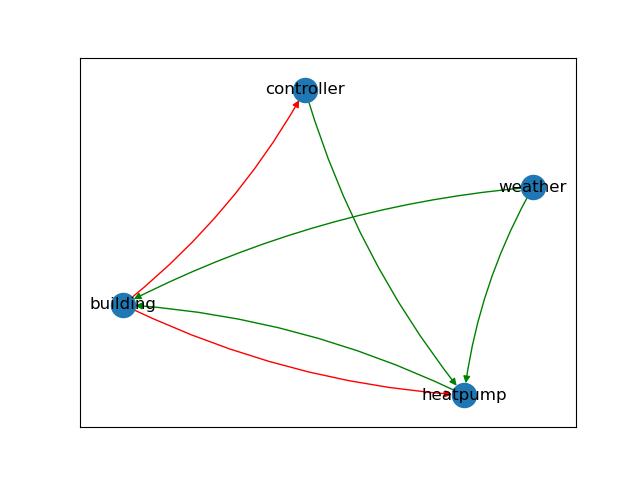

In [12]:
sim.draw_exec_graph()